<a href="https://colab.research.google.com/github/Tkag0001/Practice_NLP_with_transformer/blob/main/Multilingual_named_entity_recognition_chapter_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The dataset: Pan-x

In [1]:
!pip install transformers[torch]

In [2]:
!pip install datasets

In [3]:
from datasets import get_dataset_config_names

In [4]:
xtreme_subsets = get_dataset_config_names('xtreme')
print(f"XTREME has {len(xtreme_subsets)} configurations")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


XTREME has 183 configurations


In [5]:
# Search configurations start with "PAN"
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets

['PAN-X.af',
 'PAN-X.ar',
 'PAN-X.bg',
 'PAN-X.bn',
 'PAN-X.de',
 'PAN-X.el',
 'PAN-X.en',
 'PAN-X.es',
 'PAN-X.et',
 'PAN-X.eu',
 'PAN-X.fa',
 'PAN-X.fi',
 'PAN-X.fr',
 'PAN-X.he',
 'PAN-X.hi',
 'PAN-X.hu',
 'PAN-X.id',
 'PAN-X.it',
 'PAN-X.ja',
 'PAN-X.jv',
 'PAN-X.ka',
 'PAN-X.kk',
 'PAN-X.ko',
 'PAN-X.ml',
 'PAN-X.mr',
 'PAN-X.ms',
 'PAN-X.my',
 'PAN-X.nl',
 'PAN-X.pt',
 'PAN-X.ru',
 'PAN-X.sw',
 'PAN-X.ta',
 'PAN-X.te',
 'PAN-X.th',
 'PAN-X.tl',
 'PAN-X.tr',
 'PAN-X.ur',
 'PAN-X.vi',
 'PAN-X.yo',
 'PAN-X.zh']

In [6]:
# we have some .code to represent language such as
# German(de), French(fr), Italian(it), English(en)
from datasets import load_dataset
load_dataset('xtreme', name = 'PAN-X.de')

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [7]:
#keys and propotions each languages
from collections import defaultdict
from datasets import DatasetDict

langs = ['de', 'fr', 'it', 'en']
fracs = [0.629, 0.229, 0.084, 0.059]

# will return a datasetdict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
  # Load monolingual corpus
  ds = load_dataset('xtreme', name = f'PAN-X.{lang}')

  # shuffle and downsample each split according to spoken proportion
  for split in ds:
    panx_ch[lang][split] = (
        ds[split]
        .shuffle(seed = 0) #prevent accidentally bias
        .select(range(int(frac * ds[split].num_rows)))
    )

In [8]:
langs

['de', 'fr', 'it', 'en']

In [9]:
# number of samples in training
import pandas as pd
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index = ["Number of trainig examples"])

,de,fr,it,en
Number of trainig examples,12580,4580,1680,1180


In [10]:
# perform zero-shot cross-lingual transfer to German
element = panx_ch['de']['train'][0]
for key, value in element.items():
  print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [11]:
panx_ch['de']['train'].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None),
 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [12]:
# ner_tags column corresponds to the mapping of each entity to a class ID.
# Let's create a new column with the familiar LOC, PER, and ORG tags.

for key, value in panx_ch['de']['train'].features.items():
  print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [13]:
tags = panx_ch['de']['train'].features['ner_tags'].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [14]:
# we use ClassLabel.int2str() in chapter 2 to create new column with class names for each tag
def create_tag_names(batch):
  return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch['de'].map(create_tag_names)

In [15]:
panx_de

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})

In [16]:
de_example = panx_de["train"][2]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],['Tokens','Tags'])

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
Tokens,Dirigenten,von,Weltruf,wie,Wilhelm,Furtwängler,",",Erich,Kleiber,",",...,haben,seine,Werke,dirigiert,",",zuletzt,besonders,Horst,Stein,.
Tags,O,O,O,O,B-PER,I-PER,O,B-PER,I-PER,O,...,O,O,O,O,O,O,O,B-PER,I-PER,O


In [17]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
  for row in dataset["ner_tags_str"]:
    for tag in row:
      if tag.startswith('B'):
        tag_type = tag.split("-")[1]
        split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient = 'index')

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


#Tokenization

In [18]:
# Compare results between BERT and XLM-R tokenizer
from transformers import AutoTokenizer

bert_model_name = 'bert-base-uncased'
xlmr_model_name = 'xlm-roberta-base'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [19]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [20]:
bert_tokens

['[CLS]', 'jack', 'sparrow', 'loves', 'new', 'york', '!', '[SEP]']

In [21]:
xlmr_tokens

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']

In [22]:
pd.DataFrame([bert_tokens, xlmr_tokens],index = ['bert', 'xlmr'])

,0,1,2,3,4,5,6,7,8,9
bert,[CLS],jack,sparrow,loves,new,york,!,[SEP],None,None
xlmr,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


**We can see that instead of using [CLS], [SEP], xlmr use s and /s. It's like html tag**

# The tokenizer pipeline
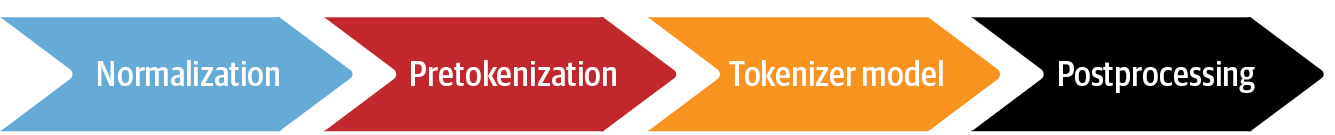

# The SentencePiece Tokenizer

In [23]:
# The weakness of previous model word piece, it lost the infor mation of
# whitespace between "York" and "!". With SentencePiece, the character '_'
# represent whitespace, so the model can detect where whitespace
''.join(xlmr_tokens).replace(u'\u2581',' ')

'<s> Jack Sparrow loves New York!</s>'

# Transformers for Named Entity Recognition

## The Anatomy of the Transformers Model Class
In normally, for our task, we choose a model and replace the last layer of it with one that is suitable for your task. This last layer is called model head.

A model combines parts: body and head

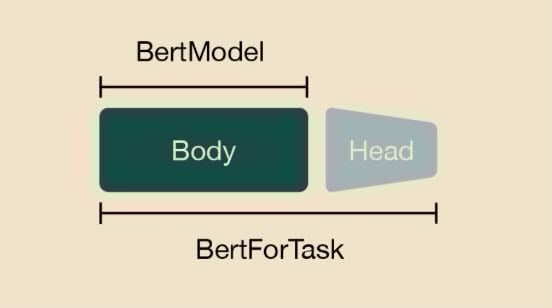

#Creating a Custom Model for Token Classification

In [24]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [25]:
# we use RoBerta as the base model, but augmented with settings specific to XLM-R
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
  config_class = XLMRobertaConfig

  def __init__(self, config):
    super().__init__(config)
    self.num_labels = config.num_labels
    # Load model body
    self.roberta = RobertaModel(config, add_pooling_layer = False)
    # Set add_pooling_layer = False to ensure all hidden states are returned
    # and not only the one associated with the [CLS] token

    # Set up token classification head
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    # Load and initialize weights
    self.init_weights()

  def forward(self, input_ids = None,
              attention_mask = None,
              token_type_ids = None,
              labels = None, **kwargs):
    # Get outputs (encoder representations) of model body
    outputs = self.roberta(input_ids, attention_mask = attention_mask,
                           token_type_ids = token_type_ids, **kwargs)

    # Define model head (classifier for encoder representation)
    sequence_output = self.dropout(outputs[0])
    logits = self.classifier(sequence_output)

    # Calculate losses
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

    # Return model output object
    return TokenClassifierOutput(loss = loss, logits = logits,
                                 hidden_states = outputs.hidden_states,
                                 attentions = outputs.attentions)

In [26]:
print(XLMRobertaForTokenClassification.__dict__)

{'__module__': '__main__', 'config_class': <class 'transformers.models.xlm_roberta.configuration_xlm_roberta.XLMRobertaConfig'>, '__init__': <function XLMRobertaForTokenClassification.__init__ at 0x79d1084aeb90>, 'forward': <function XLMRobertaForTokenClassification.forward at 0x79d1084aecb0>, '__doc__': None}


# Loading a Custom model

In [27]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [28]:
# Load config by AutoConfig
from transformers import AutoConfig

In [29]:
# View original config
xlmr_config_ori = AutoConfig.from_pretrained(xlmr_model_name)
xlmr_config_ori

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [30]:
# View customize config
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels = tags.num_classes,
                                         id2label = index2tag,
                                         label2id = tag2index)

In [31]:
xlmr_config

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 5,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [32]:
import torch

In [33]:
# Load the model weights by inheriting from RobertaPreTrainedModel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config = xlmr_config)
              .to(device))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
input_ids = xlmr_tokenizer.encode(text, return_tensors = 'pt')
input_ids

tensor([[    0, 21763, 37456, 15555,  5161,     7,  2356,  5753,    38,     2]])

In [35]:
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index = ['Tokens', 'Input IDs'])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [36]:
# Predict the input
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim = -1)
print(f'Number of tokens in sequence: {len(xlmr_tokens)}')
print(f'Shape of outputs: {outputs.shape}')

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [37]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index = ['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG


In [38]:
# define function to predict
def tag_text(text, tags, model, tokenizer):
  # Get tokens with special characters
  tokens = tokenizer(text).tokens()
  # Encode the sequence into IDs
  input_ids = xlmr_tokenizer(text, return_tensors = 'pt').input_ids.to(device)
  # Get predictions as distribution over 7 possible classes
  outputs = model(input_ids)[0]
  # Take argmax to get most likely class per token
  predictions = torch.argmax(outputs, dim = 2)
  # Convert to DataFrame
  preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
  return pd.DataFrame([tokens, preds], index = ['Tokens', 'Tags'])

In [39]:
tag_text("I love you so much, but this love is just from me.",
         tags,
         xlmr_model,
         xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Tokens,<s>,▁I,▁love,▁you,▁so,▁much,",",▁but,▁this,▁love,▁is,▁just,▁from,▁me,.,</s>
Tags,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG


# Tokenizer texts for NER

In [40]:
print(de_example)

{'tokens': ['Dirigenten', 'von', 'Weltruf', 'wie', 'Wilhelm', 'Furtwängler', ',', 'Erich', 'Kleiber', ',', 'Wolfgang', 'Sawallisch', ',', 'Karl', 'Böhm', ',', 'Herbert', 'von', 'Karajan', ',', 'Rafael', 'Kubelík', ',', 'Erich', 'Kleiber', ',', 'Bernard', 'Haitink', ',', 'Josef', 'Krips', ',', 'Zubin', 'Mehta', ',', 'Dimitri', 'Mitropoulos', ',', 'Antal', 'Doráti', ',', 'Sergiu', 'Celibidache', 'und', 'andere', 'haben', 'seine', 'Werke', 'dirigiert', ',', 'zuletzt', 'besonders', 'Horst', 'Stein', '.'], 'ner_tags': [0, 0, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0], 'langs': ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de'

In [41]:
words, labels = de_example['tokens'], de_example['ner_tags']

In [42]:
print(words)

['Dirigenten', 'von', 'Weltruf', 'wie', 'Wilhelm', 'Furtwängler', ',', 'Erich', 'Kleiber', ',', 'Wolfgang', 'Sawallisch', ',', 'Karl', 'Böhm', ',', 'Herbert', 'von', 'Karajan', ',', 'Rafael', 'Kubelík', ',', 'Erich', 'Kleiber', ',', 'Bernard', 'Haitink', ',', 'Josef', 'Krips', ',', 'Zubin', 'Mehta', ',', 'Dimitri', 'Mitropoulos', ',', 'Antal', 'Doráti', ',', 'Sergiu', 'Celibidache', 'und', 'andere', 'haben', 'seine', 'Werke', 'dirigiert', ',', 'zuletzt', 'besonders', 'Horst', 'Stein', '.']


In [43]:
print(labels)

[0, 0, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0]


In [44]:
# View tokens from xlmr
tokenized_input = xlmr_tokenizer(de_example['tokens'], is_split_into_words = True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])
pd.DataFrame([tokens], index=['Tokens'])

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
Tokens,<s>,▁Dirigent,en,▁von,▁Welt,ruf,▁wie,▁Wilhelm,▁Fur,tw,...,▁,",",▁zuletzt,▁besonders,▁Hor,st,▁Stein,▁,.,</s>


In [45]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index = ['Tokens', 'Word IDS'])

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
Tokens,<s>,▁Dirigent,en,▁von,▁Welt,ruf,▁wie,▁Wilhelm,▁Fur,tw,...,▁,",",▁zuletzt,▁besonders,▁Hor,st,▁Stein,▁,.,</s>
Word IDS,None,0,0,1,2,2,3,4,5,5,...,49,49,50,51,52,52,53,54,54,None


In [46]:
# Set -100 as the label for special tokens and subwords we wish to mask during training.
# Special tokens: <s>, </s>, ...
previous_word_idx = None
label_ids = []
for word_idx in word_ids:
  if word_idx is None or word_idx == previous_word_idx:
    label_ids.append(-100)
  elif word_idx != previous_word_idx:
    label_ids.append(labels[word_idx])
  previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else 'IGN' for l in label_ids]
index = ['Tokens', 'Word IDs', 'Label IDs', 'Labels']

pd.DataFrame([tokens, word_ids, label_ids, labels], index = index)

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
Tokens,<s>,▁Dirigent,en,▁von,▁Welt,ruf,▁wie,▁Wilhelm,▁Fur,tw,...,▁,",",▁zuletzt,▁besonders,▁Hor,st,▁Stein,▁,.,</s>
Word IDs,None,0,0,1,2,2,3,4,5,5,...,49,49,50,51,52,52,53,54,54,None
Label IDs,-100,0,-100,0,0,-100,0,1,2,-100,...,0,-100,0,0,1,-100,2,0,-100,-100
Labels,IGN,O,IGN,O,O,IGN,O,B-PER,I-PER,IGN,...,O,IGN,O,O,B-PER,IGN,I-PER,O,IGN,IGN


In [47]:
def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples['tokens'], truncation = True,
                                    is_split_into_words = True)
  labels = []
  for idx, label in enumerate(examples['ner_tags']):
    word_ids = tokenized_inputs.word_ids(batch_index = idx)
    previous_word_ids = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx is None or word_idx == previous_word_ids:
        label_ids.append(-100)
      else:
        label_ids.append(label[word_idx])
      previous_word_ids = word_idx
    labels.append(label_ids)
  tokenized_inputs['labels'] = labels
  return tokenized_inputs

In [48]:
def encode_panx_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched = True,
                    remove_columns = ['langs', 'ner_tags', 'tokens'])

In [49]:
panx_de_encoded = encode_panx_dataset(panx_ch['de'])

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [50]:
panx_de_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
})

# Performance measures

In [51]:
!pip install seqeval

In [52]:
# Example of evaluate
from seqeval.metrics import classification_report

In [53]:
y_true = [['O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'O'],
          ['B-PER', 'I-PER', 'O']]

y_pred = [['O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O'],
          ['B-PER', 'I-PER', 'O']]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [54]:
import numpy as np

In [55]:
def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis = 2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      # Ignore label IDs = -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])

      labels_list.append(example_labels)
      preds_list.append(example_preds)

    return preds_list, labels_list

# Fine-Tuning XLMR-RoBERTa

In [56]:
from transformers import TrainingArguments

In [57]:
!pip install accelerate -U

In [58]:
num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded['train']) // batch_size
model_name = f'{xlmr_model_name}-fintuned-panx-de_ver2-26072024'
training_args = TrainingArguments(
    output_dir = model_name,
    log_level = 'error',
    num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    evaluation_strategy = 'epoch',
    save_steps = 1e6, weight_decay = 0.01,
    disable_tqdm = False,
    logging_steps = logging_steps,
    push_to_hub = True
)

In [59]:
from huggingface_hub import notebook_login

In [60]:
notebook_login()

In [61]:
from seqeval.metrics import f1_score

In [62]:
def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions,
                                     eval_pred.label_ids)
  return {'f1': f1_score(y_true, y_pred)}

In [63]:
from transformers import DataCollatorForTokenClassification

In [64]:
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [65]:
def model_init():
  return (XLMRobertaForTokenClassification
          .from_pretrained(xlmr_model_name, config = xlmr_config)
          .to(device))

In [66]:
from transformers import Trainer

In [ ]:
trainer = Trainer(model_init = model_init, args = training_args,
                  data_collator = data_collator, compute_metrics = compute_metrics,
                  train_dataset = panx_de_encoded['train'],
                  eval_dataset = panx_de_encoded['validation'],
                  tokenizer = xlmr_tokenizer)

In [ ]:
trainer.train()
trainer.push_to_hub(commit_message = 'Training completed!')
# trainer.push_to_hub = False

In [ ]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

# Error analysis
Investigate the errors of model.
Why do we need to do that?
There are several failure modes where it might look like the model is performing well, while in practice it has some serious flaws.
Some training can fail include:
- Mask too many tokens and also mask some of our labels to get a really promising loss drop.
- The compute_metrics() function might have a bug that overestimates the true performance.
- With a lot of 0 entities or zero classes, it will be ambigious because 0 classes are the majority class by a large margin.

In [67]:
from torch.nn.functional import cross_entropy

In [68]:
def forward_pass_with_label(batch):
  # Convert dict of lists to list of dicts suitable for data collator
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]
  # Pad inputs and labels and put all tensprs on
  batch = data_collator(features)
  input_ids = batch['input_ids'].to(device)
  attention_mask = batch['attention_mask'].to(device)
  labels = batch['labels'].to(device)
  with torch.no_grad():
    # Pass data through model
    output = trainer.model(input_ids, attention_mask)
    # logit.size: [batch_size, sequence_length, classes]
    # Predict class with largest logit value on classes axis
    predicted_label = torch.argmax(output.logits, dim = -1)
  # Calculate loss per token after flattening batch dimension with view
  loss = cross_entropy(output.logits.view(-1,7),
                       labels.view(-1), reduction = 'none')
  # Unflatten batch dimension and convert to numpy array
  loss = loss.view(len(input_ids), -1).cpu().numpy()
  return {'loss': loss, 'predicted_label': predicted_label}

In [69]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForTokenClassification

In [70]:
# This code is used to reload model from huggingface. If you don't reload, please across it.
model_loaded = AutoModelForTokenClassification.from_pretrained("Tkag/xlm-roberta-base-fintuned-panx-de_ver2-23072024")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/988 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [71]:
# This code is used to reload model from huggingface. If you don't reload, please across it.
trainer = Trainer(model = model_loaded, args = training_args,
                  compute_metrics = compute_metrics,
                  data_collator = data_collator)
trainer.model = model_loaded.to(device)

In [72]:
valid_set = panx_de_encoded['validation']
valid_set = valid_set.map(forward_pass_with_label, batched = True, batch_size = 32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [73]:
df

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, 4, 4, -100]","[0.0, 0.02170534, 0.0, 0.022078084, 0.01524780...","[0, 3, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, -100, -100, -100, 3, -100, -10...","[0.0, 0.00032348168, 0.0, 0.0, 0.0, 0.0, 0.472...","[0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 4, 4, 4, ..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 0, 3, -100, -100, 0, -100, 0, ...","[0.0, 0.00030286494, 0.00017414961, 0.00019774...","[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 5, -100, 0, 0, -100]","[0.0, 0.00036864638, 0.00020180097, 0.00021062...","[0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, ...","[0.0, 0.00021371941, 0.00018666433, 0.00024589...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, ..."
...,...,...,...,...,...
6285,"[0, 10333, 599, 7418, 4180, 72, 3700, 542, 900...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, -10...","[0.0, 0.00016938205, 0.00016854773, 0.00017939...","[0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 0, 0, ..."
6286,"[0, 15497, 7, 91243, 15, 23924, 96220, 1388, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 5, -100, -100, 6, 6, 6, 6, -100]","[0.0, 0.010138088, 0.0, 0.0, 0.014203527, 0.01...","[6, 5, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, ..."
6287,"[0, 1858, 566, 12241, 729, 4598, 89841, 68125,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, -100, 0, -100, -100, 0, 0, ...","[0.0, 0.00019512657, 0.00021479207, 0.00028451...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6288,"[0, 132005, 11399, 7, 84974, 168, 34525, 84247...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, -100, 0, 0, 5, 6, 0, 0, -100, -100]","[0.0, 0.00028272448, 0.0010342017, 0.0, 0.0002...","[0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, ..."


In [74]:
type(df)

pandas.core.frame.DataFrame

In [75]:
# Convert to view easily
index2tag[-100] = 'IGN'
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x)
)
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x]
)
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x]
)
df["loss"] = df.apply(
    lambda x: x["loss"][:len(x["input_ids"])], axis=1)
df["predicted_label"] = df.apply(
    lambda x: x["predicted_label"][:len(x["input_ids"])], axis=1)

In [76]:
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.02170534, 0.0, 0.022078084, 0.01524780...","[O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [77]:
# Show a dataframe about tokens
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens['loss'] = df_tokens['loss'].astype(float).round(2)
df_tokens

<ipython-input-77-398c445f5616>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokens['loss'] = df_tokens['loss'].astype(float).round(2)


,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.02,B-ORG,▁Ham
0,15,1,I-ORG,0.02,I-ORG,▁(
0,16104,1,I-ORG,0.02,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.02,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
...,...,...,...,...,...,...
6289,242,1,O,0.00,O,▁'
6289,5106,1,O,0.00,O,▁''
6289,223660,1,B-PER,3.61,B-LOC,▁Alabama
6289,5106,1,O,0.00,O,▁''


In [78]:
# group and aggregate the losses for each token
(df_tokens.groupby('input_tokens')[['loss']]
 .agg(['count', 'mean', 'sum'])
 .droplevel(level = 0, axis = 1)
 .sort_values(by = 'sum', ascending = False)
 .reset_index()
 .round(2)
 .head(10)
 .T)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁in,▁von,▁/,▁und,▁'',▁(,▁),▁A
count,6066,1388,989,808,163,1171,2898,246,246,125
mean,0.03,0.1,0.11,0.14,0.55,0.07,0.02,0.26,0.25,0.42
sum,203.05,137.69,112.47,112.05,90.33,82.58,66.33,64.24,62.58,52.64


In [79]:
(df_tokens.groupby('labels')[['loss']]
 .agg(['count', 'mean', 'sum'])
 .droplevel(level = 0, axis = 1)
 .sort_values(by = 'sum', ascending = False)
 .reset_index()
 .round(2)
 .T)

,0,1,2,3,4,5,6
labels,I-ORG,B-ORG,O,B-LOC,B-PER,I-LOC,I-PER
count,3820,2683,43648,3172,2893,1462,4139
mean,0.48,0.59,0.03,0.33,0.29,0.55,0.19
sum,1818.6,1595.73,1309.24,1061.5,826.25,800.01,784.41


In [80]:
# Evaluate with confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [81]:
from matplotlib import pyplot as plt

In [82]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize = 'true')
  fig, ax = plt.subplots(figsize = (10,10))
  disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
  disp.plot(cmap = 'Blues', values_format = '.2f', ax = ax, colorbar = False)
  plt.title('Normalized confusion matrix')
  plt.show()

In [83]:
df_tokens.columns

Index(['input_ids', 'attention_mask', 'labels', 'loss', 'predicted_label',
       'input_tokens'],
      dtype='object')

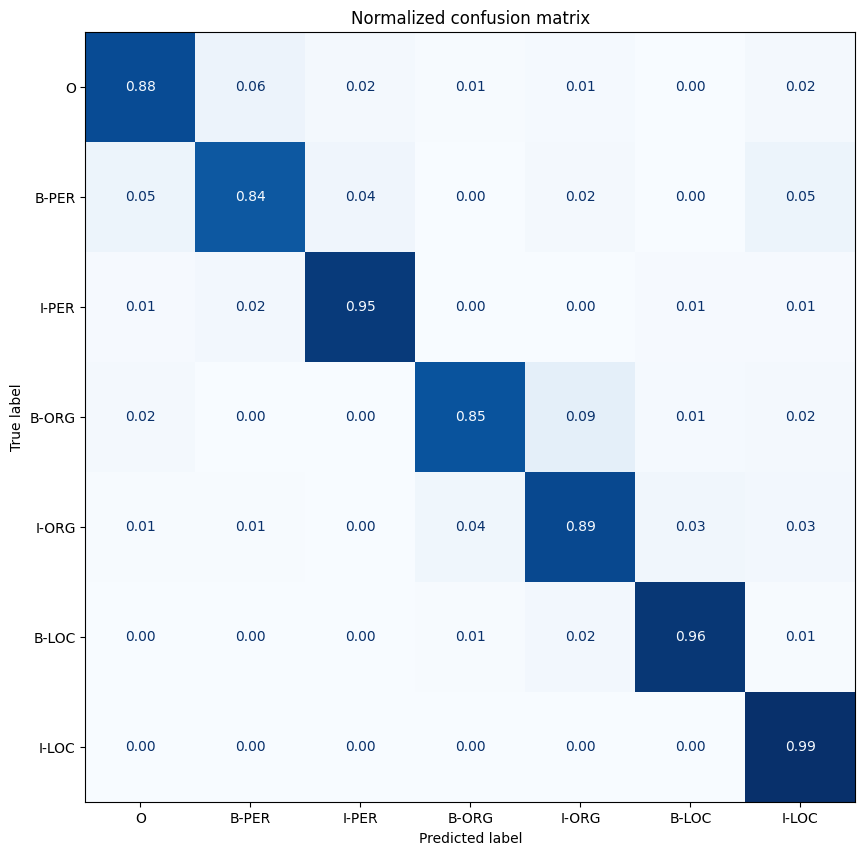

In [84]:
plot_confusion_matrix(df_tokens['labels'], df_tokens['predicted_label'], tags.names)

In [85]:
def get_samples(df):
  for _, row in df.iterrows():
    labels, preds, tokens, losses = [], [], [], []
    for i, mask in enumerate(row['attention_mask']):
      if i not in {0, len(row['attention_mask'])}:
        labels.append(row['labels'][i])
        preds.append(row['predicted_label'][i])
        tokens.append(row['input_tokens'][i])
        losses.append(f"{row['loss'][i]:.2f}")
    df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                           "preds": preds, "losses": losses}).T
    yield df_tmp

In [86]:
df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by = 'total_loss', ascending = False).head(5)

for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,9.11,0.00,0.00,7.05,9.55,9.57,6.86,0.00,8.69,8.72,7.45,6.18,4.30,0.00,0.00,0.03,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,B-ORG,O,O,I-ORG,O,O,O,O,O,I-ORG,O
losses,0.00,0.00,4.84,0.00,0.00,0.00,10.29,9.99,7.37,4.96,4.18,0.00,5.71,6.32,0.00,6.44,5.58,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,6.31,5.72,5.51,0.00,5.35,0.00,5.12,0.00,5.26,4.97,5.13,5.39,5.28,5.25,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁1988,▁in,▁Auckland,▁und,▁1989,▁in,▁Stavanger,▁tru,g,▁er,▁mit,▁einem,▁sie,b,ten,▁bzw,▁,.,</s>
labels,B-ORG,I-ORG,I-ORG,O,B-ORG,I-ORG,I-ORG,O,IGN,O,O,O,O,IGN,IGN,O,O,IGN,IGN
preds,O,O,B-LOC,O,O,O,B-LOC,O,O,O,O,O,O,O,O,O,O,O,O
losses,6.21,9.07,6.69,0.00,5.25,8.82,6.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁Bei,▁ges,check,ten,▁Pferde,n,▁können,▁unterschiedlich,e,▁Gene,▁für,▁die,▁Farbe,▁verantwortlich,▁sein,▁,.,</s>
labels,O,B-ORG,IGN,IGN,I-ORG,IGN,O,O,IGN,B-ORG,I-ORG,I-ORG,I-ORG,O,O,O,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,6.15,0.00,0.00,2.82,0.00,0.00,0.00,0.00,4.23,9.77,9.94,8.36,0.00,0.00,0.00,0.00,0.00


In [87]:
df_tmp = df.loc[df['input_tokens'].apply(lambda x: u'\u2581(' in x)].head(5)
for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.02,0.00,0.02,0.02,0.02,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,O
losses,0.03,0.00,0.00,0.02,0.02,0.00,0.01,0.00


,0,1,2,3,4,5,6,7,8,9,10,11
tokens,▁Pik,e,▁Town,ship,▁(,▁Brown,▁County,▁,",",▁Ohio,▁),</s>
labels,B-LOC,IGN,I-LOC,IGN,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,O
losses,0.05,0.00,0.03,0.00,0.02,0.03,0.02,0.02,0.00,0.02,0.02,0.00


,0,1,2,3,4,5,6
tokens,▁Bad,▁Grund,▁(,▁Har,z,▁),</s>
labels,B-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,O
losses,0.05,0.03,0.02,0.02,0.00,0.02,0.00


,0,1,2,3,4,5,6,7,8
tokens,▁Al,fon,s,▁VI,.,▁(,▁León,▁),</s>
labels,B-PER,IGN,IGN,I-PER,IGN,I-PER,I-PER,I-PER,IGN
preds,B-PER,B-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,O
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# Cross-Lingual Transfer

In [88]:
def get_f1_score(trainer, dataset):
  return trainer.predict(dataset).metrics["test_f1"]

In [89]:
def get_loss_score(trainer, dataset):
  return trainer.predict(dataset).metrics["test_loss"]

In [90]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded['test'])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 1.000


In [91]:
loss_scores = defaultdict(dict)
loss_scores["de"]["de"] = get_loss_score(trainer, panx_de_encoded['test'])
print(f"Loss-score of [de] model on [de] dataset: {loss_scores['de']['de']:.3f}")

Loss-score of [de] model on [de] dataset: 0.134


In [92]:
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 1.000


In [93]:
print(f"Loss-score of [de] model on [de] dataset: {loss_scores['de']['de']:.3f}")

Loss-score of [de] model on [de] dataset: 0.134


In [94]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [95]:
def evaluate_lang_performance(lang, trainer):
  panx_ds = encode_panx_dataset(panx_ch[lang])
  return get_f1_score(trainer, panx_ds['test']), get_loss_score(trainer, panx_ds['test'])

In [96]:
# def evaluate_lang_performance_loss_score(lang, trainer):
#   panx_ds = encode_panx_dataset(panx_ch[lang])
#   return get_loss_score(trainer, panx_ds['test'])

In [97]:
f1_scores['de']['fr'], loss_scores['de']['fr'] = evaluate_lang_performance('fr', trainer)
print(f"F1-score of [de] model on [fr] datset: {f1_scores['de']['fr']:.3f}")
print(f"Loss-score of [de] model on [fr] datset: {loss_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

F1-score of [de] model on [fr] datset: 1.000
Loss-score of [de] model on [fr] datset: 0.838


In [98]:
f1_scores['de']['it'], loss_scores['de']['it'] = evaluate_lang_performance('it', trainer)
print(f"F1-score of [de] model on [it] datset: {f1_scores['de']['it']:.3f}")
print(f"Loss-score of [de] model on [it] datset: {loss_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

F1-score of [de] model on [it] datset: 1.000
Loss-score of [de] model on [it] datset: 0.721


In [99]:
f1_scores['de']['en'], loss_scores['de']['en']  = evaluate_lang_performance('en', trainer)
print(f"F1-score of [de] model on [en] datset: {f1_scores['de']['en']:.3f}")
print(f"Loss-score of [de] model on [en] datset: {loss_scores['de']['en']:.3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

F1-score of [de] model on [en] datset: 1.000
Loss-score of [de] model on [en] datset: 0.829


In [100]:
f1_scores

defaultdict(dict, {'de': {'de': 1.0, 'fr': 1.0, 'it': 1.0, 'en': 1.0}})

In [101]:
loss_scores

defaultdict(dict,
            {'de': {'de': 0.13421179354190826,
              'fr': 0.8378785848617554,
              'it': 0.7211098074913025,
              'en': 0.8290817141532898}})

In [102]:
# loss_scores["de"]["fr"] = get_loss_score(trainer, panx_de_encoded['test'])
# print(f"Loss-score of [de] model on [fr] dataset: {loss_scores['de']['fr']:.3f}")

In [103]:
# loss_scores["de"]["it"] = get_loss_score(trainer, panx_de_encoded['test'])
# print(f"Loss-score of [de] model on [it] dataset: {loss_scores['de']['it']:.3f}")

In [104]:
# loss_scores["de"]["en"] = get_loss_score(trainer, panx_de_encoded['test'])
# print(f"Loss-score of [de] model on [en] dataset: {loss_scores['de']['en']:.3f}")

# When Does Zero-Shot Transfer Make Sense

In [105]:
def train_on_subset(dataset, num_samples):
  train_ds = dataset['train'].shuffle().select(range(num_samples))
  valid_ds = dataset['validation']
  test_ds = dataset['test']
  training_args.logging_steps = len(train_ds)//batch_size

  trainer = Trainer(model_init = model_init, args = training_args,
                    data_collator = data_collator, compute_metrics = compute_metrics,
                    train_dataset = train_ds, eval_dataset = valid_ds, tokenizer = xlmr_tokenizer)
  trainer.train()
  if training_args.push_to_hub:
    trainer.push_to_hub(commit_message = f"Training completed!")

  f1_score = get_f1_score(trainer, test_ds)
  loss_score = get_loss_score(trainer, test_ds)
  return pd.DataFrame.from_dict({"num_samples": [len(train_ds)], "f1_score": [f1_score]}), pd.DataFrame.from_dict({"num_samples": [len(train_ds)], "loss_score": [loss_score]})

In [ ]:
# def train_on_subset_loss(dataset, num_samples):
#   train_ds = dataset['train'].shuffle().select(range(num_samples))
#   valid_ds = dataset['validation']
#   test_ds = dataset['test']
#   training_args.logging_steps = len(train_ds)//batch_size

#   trainer = Trainer(model_init = model_init, args = training_args,
#                     data_collator = data_collator, compute_metrics = compute_metrics,
#                     train_dataset = train_ds, eval_dataset = valid_ds, tokenizer = xlmr_tokenizer)
#   trainer.train()
#   if training_args.push_to_hub:
#     trainer.push_to_hub(commit_message = f"Training completed!")

#   loss_score = get_loss_score(trainer, test_ds)
#   return pd.DataFrame.from_dict({"num_samples": [len(train_ds)], "loss_score": [loss_score]})

In [106]:
panx_fr_encoded = encode_panx_dataset(panx_ch['fr'])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

In [107]:
panx_fr_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4580
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2290
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2290
    })
})

In [108]:
training_args.push_to_hub = False
metrics_df_f1, metrics_df_loss = train_on_subset(panx_fr_encoded, 250)
metrics_df_f1
metrics_df_loss

Epoch,Training Loss,Validation Loss,F1
1,1.611400,1.302332,0.000000
2,1.186100,1.002813,0.000000
3,0.996400,0.926670,0.000000


,num_samples,loss_score
0,250,0.925993


In [109]:
metrics_df_f1

,num_samples,f1_score
0,250,0.0


In [110]:
for num_samples in [500, 1000, 2000, 4000]:
  metrics_f1, metrics_loss = train_on_subset(panx_fr_encoded, num_samples)
  metrics_df_f1 = pd.concat([metrics_df_f1, metrics_f1],
                                 ignore_index = True)
  metrics_df_loss = pd.concat([metrics_df_loss, metrics_loss],
                                 ignore_index = True)

Epoch,Training Loss,Validation Loss,F1
1,1.424700,1.032997,0.000000
2,0.868600,0.663675,1.000000
3,0.594300,0.572499,1.000000


Epoch,Training Loss,Validation Loss,F1
1,1.070700,0.550981,0.000000
2,0.452200,0.420656,0.000000
3,0.301100,0.392806,1.000000


Epoch,Training Loss,Validation Loss,F1
1,0.774600,0.425947,0.000000
2,0.321700,0.344122,1.000000
3,0.204100,0.333724,1.000000


Epoch,Training Loss,Validation Loss,F1
1,0.587900,0.336354,1.000000
2,0.274500,0.304830,1.000000
3,0.178800,0.285479,1.000000


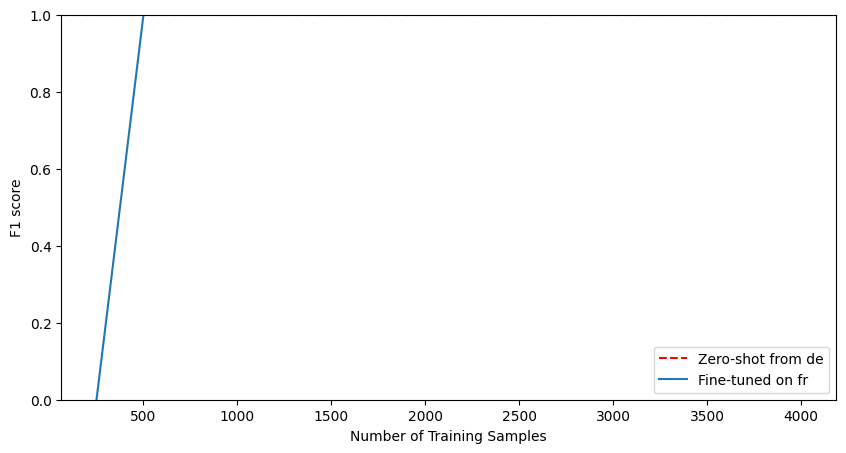

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.axhline(f1_scores['de']['fr'], ls = '--', color = 'r')
metrics_df_f1.set_index('num_samples').plot(ax = ax)
plt.legend(['Zero-shot from de', 'Fine-tuned on fr'], loc = 'lower right')
plt.ylim((0,1))
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 score')
plt.show()

In [ ]:
metrics_df_f1

,num_samples,f1_score
0,250,0.0
1,500,1.0
2,1000,1.0
3,2000,1.0
4,4000,1.0


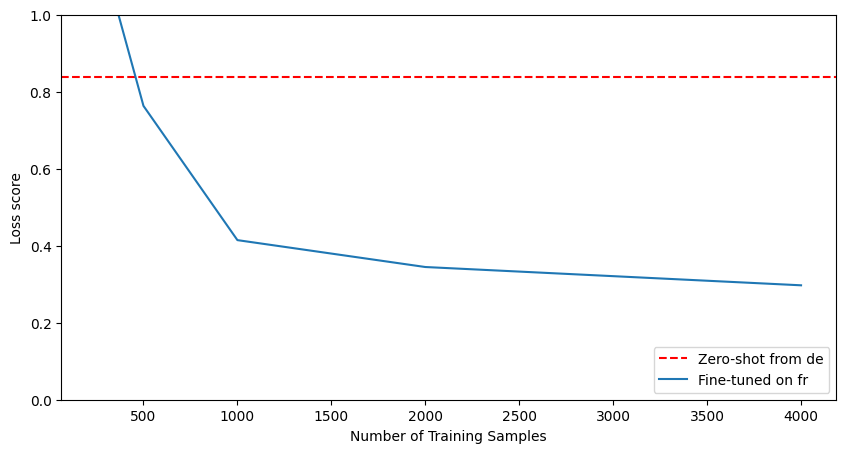

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.axhline(loss_scores['de']['fr'], ls = '--', color = 'r')
metrics_df_loss.set_index('num_samples').plot(ax = ax)
plt.legend(['Zero-shot from de', 'Fine-tuned on fr'], loc = 'lower right')
plt.ylim((0,1))
plt.xlabel('Number of Training Samples')
plt.ylabel('Loss score')
plt.show()

In [ ]:
# metrics_df_loss = train_on_subset_loss(panx_fr_encoded, 250)
# metrics_df_loss

In [ ]:
# for num_samples in [500, 1000, 2000, 4000]:
#   metrics_df_loss = pd.concat([metrics_df_loss, train_on_subset_loss(panx_fr_encoded, num_samples)],
#                                  ignore_index = True)

# fig, ax = plt.subplots(figsize = (10, 8))
# ax.axhline(loss_scores['de']['fr'], ls = '--', color = 'r')
# metrics_df_loss.set_index('num_samples').plot(ax = ax)
# plt.legend(['Zero-shot from de', 'Fine-tuned on fr'], loc = 'lower right')
# plt.ylim((0,1))
# plt.xlabel('Number of Training Samples')
# plt.ylabel('Loss score')
# plt.show()

In [ ]:
metrics_df_loss

,num_samples,loss_score
0,250,1.207674
1,500,0.763202
2,1000,0.414540
3,2000,0.344694
4,4000,0.297195


# Fine-tuning on Multiple Languages at Once

In [111]:
from datasets import concatenate_datasets

In [112]:
def concatenate_splits(corpora):
  multi_corpus = DatasetDict()
  for split in corpora[0].keys():
    multi_corpus[split] = concatenate_datasets(
        [corpus[split] for corpus in corpora]).shuffle(seed=42)
  return multi_corpus

In [117]:
panx_en_encoded = encode_panx_dataset(panx_ch['en'])
panx_it_encoded = encode_panx_dataset(panx_ch['it'])

In [118]:
panx_multi_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded, panx_en_encoded, panx_it_encoded])
panx_multi_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 20020
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10010
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10010
    })
})

In [120]:
training_args.logging_steps = len(panx_multi_encoded['train']) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlmr-roberta-base-fintuned-panx-multi-27-07-2024"

trainer = Trainer(model_init = model_init, args = training_args,
                  data_collator = data_collator, compute_metrics = compute_metrics,
                  tokenizer = xlmr_tokenizer, train_dataset = panx_multi_encoded["train"],
                  eval_dataset = panx_multi_encoded["validation"])

trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.292700,0.210247,0.000000


Epoch,Training Loss,Validation Loss,F1
1,0.292700,0.210247,0.000000
2,0.158100,0.177700,1.000000
3,0.103600,0.177756,1.000000


AttributeError: 'Trainer' object has no attribute 'push'

In [121]:
trainer.push_to_hub(commit_message = "Init: Training completed!")

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Tkag/xlmr-roberta-base-fintuned-panx-multi-27-07-2024/commit/631e591e8f173b539f141c896e92293005cf2b0b', commit_message='Init: Training completed!', commit_description='', oid='631e591e8f173b539f141c896e92293005cf2b0b', pr_url=None, pr_revision=None, pr_num=None)

In [122]:
for lang in langs:
  f1, loss = evaluate_lang_performance(lang,trainer)
  print(f"F1-score of multi-lang model on [{lang}] dataset: {f1:.3f}")
  print(f"Loss-score of multi-lang model on [{lang}] dataset: {f1:.3f}")
  print("------------------------------------------------------------")

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

F1-score of multi-lang model on [de] dataset: 1.000
Loss-score of multi-lang model on [de] dataset: 1.000
------------------------------------------------------------


F1-score of multi-lang model on [fr] dataset: 1.000
Loss-score of multi-lang model on [fr] dataset: 1.000
------------------------------------------------------------


F1-score of multi-lang model on [it] dataset: 1.000
Loss-score of multi-lang model on [it] dataset: 1.000
------------------------------------------------------------


F1-score of multi-lang model on [en] dataset: 1.000
Loss-score of multi-lang model on [en] dataset: 1.000
------------------------------------------------------------


In [123]:
corpora = [panx_de_encoded]

## Train on each subset

In [124]:
for lang in langs[1:]:
  training_args.output_dir = f"xlmr-roberta-base-fintuned-panx-multi-{lang}-27-07-2024"
  # Fine-tune on monolingual corpus
  ds_encoded = encode_panx_dataset(panx_ch[lang])
  metrics_f1, metrics_loss = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
  # Collect F1-scores in common dict
  f1_scores[lang][lang] = metrics_f1["f1_score"][0]
  loss_scores[lang][lang] = metrics_loss["loss_score"][0]
  # Add monolingual corpus to list of corpora to concatenate
  corpora.append(ds_encoded)

Epoch,Training Loss,Validation Loss,F1
1,0.564700,0.324449,1.000000
2,0.267100,0.268076,1.000000
3,0.174400,0.274189,1.000000


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1
1,0.721700,0.328175,1.000000
2,0.273600,0.282378,1.000000
3,0.183800,0.267881,1.000000


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1
1,1.047900,0.502897,1.000000
2,0.460400,0.414481,1.000000
3,0.379700,0.407527,1.000000


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

In [125]:
corpora_encoded = concatenate_splits(corpora)

## Another way to train on all

In [126]:
training_args.logging_steps = len(corpora_encoded['train']) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init = model_init, args = training_args,
                  data_collator = data_collator, compute_metrics = compute_metrics,
                  tokenizer = xlmr_tokenizer, train_dataset = corpora_encoded["train"],
                  eval_dataset = corpora_encoded["validation"])

trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.299000,0.211163,1.000000
2,0.158700,0.174086,1.000000
3,0.101200,0.179075,1.000000


TypeError: Trainer.create_model_card() got an unexpected keyword argument 'commit_messages'

In [127]:
trainer.push_to_hub(commit_message = "Init: Training completed!")

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Tkag/xlm-roberta-base-finetuned-panx-all/commit/04e4a3db15dbe91b2ef918e7c1c411b583a0d2a6', commit_message='Init: Training completed!', commit_description='', oid='04e4a3db15dbe91b2ef918e7c1c411b583a0d2a6', pr_url=None, pr_revision=None, pr_num=None)

In [1]:
for idx, lang in enumerate(langs):
  f1_scores['all'][lang], loss_scores['all'][lang] = evaluate_lang_performance(lang, trainer)

f1_scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(f1_scores_data).T.Round(4)
f1_scores_df.rename_axis(index = "Fine-tune on", columns = "Evaluate on",
                         inplace = True)
f1_scores_df

NameError: name 'langs' is not defined

In [ ]:
loss_scores_data = {"de": loss_scores["de"],
               "each": {lang: loss_scores[lang][lang] for lang in langs},
               "all": loss_scores["all"]}
loss_scores_df = pd.DataFrame(loss_scores_data).T.Round(4)
loss_scores_df.rename_axis(index = "Fine-tune on", columns = "Evaluate on",
                         inplace = True)
loss_scores_df